# Analytics Vidhya Competition
## Data Science Hackathon
## Feburary 2018


***

### Problem Statement

Country Beeristan, a high potential market, accounts for nearly 10% of Stallion & Co.’s global beer sales. Stallion & Co. has a large portfolio of products distributed to retailers through wholesalers (agencies). There are thousands of unique wholesaler-SKU/products combinations. In order to plan its production and distribution as well as help wholesalers with their planning, it is important for Stallion & Co. to have an accurate estimate of demand at SKU level for each wholesaler.

Currently demand is estimated by sales executives, who generally have a “feel” for the market and predict the net effect of forces of supply, demand and other external factors based on past experience. The more experienced a sales exec is in a particular market, the better a job he does at estimating. Joshua, the new Head of S&OP for Stallion & Co. just took an analytics course and realized he can do the forecasts in a much more effective way. He approaches you, the best data scientist at Stallion, to transform the exercise of demand forecasting.

### Datasets

You are provided with the following data:

- price_sales_promotion.csv: (\$/hectoliter) Holds the price, sales & promotion in dollar value per hectoliter at Agency-SKU-month level
- historical_volume.csv: \(hectoliters\) Holds sales data at Agency-SKU-month level from Jan 2013 to Dec 2017
- weather.csv: (Degree Celsius) Holds average maximum temperature at Agency-month level
- industry_soda_sales.csv: (hectoliters) Holds industry level soda sales
- event_calendar.csv: Holds event details (sports, carnivals, etc.)
- industry_volume.csv: (hectoliters) Holds industry actual beer volume
- demographics.csv: Holds demographic details (Yearly income in $)

### Submission Formats

1. Volume_forecast.csv: You need to first forecast the demand volume for Jan’18 of all agency-SKU combination.
1. sku_recommendation.csv: Secondly, you need to suggest 2 SKUs which can be sold by Agency06 & Agency14. These two agencies are new and company wants to find out which two products would be the best products for these two agencies.

Summarize the analysis carried out in a one pager mentioning the techniques used for forecasting and the approach to arrive at the suggested SKUs for Agency06 & Agency14.

### Evaluation Metrics

**Forecasting Score:** Forecast accuracy will be calculated using the following formula:

![forcasting formula](images/final_eqn_abinbev1-e1519195839730.jpg)

**Recommendation Score:** It is based on exact match with correct sku set (Actual SKU set). Score would be:

- 1 if both the recommeded SKUs are among the correct skus
- 0.5 if only one sku is among the correct skus
- 0 if no sku is among the correct skus

#### Public and Private Score:

* For Forecasting, public and private split is 20:80 on agency level i.e. 12 agencies are in public and 46 agencies are in private.
* Public leaderboard score is based on forecast accuracy only which is evaluated on the public part of the test file
* Private Leaderboard Score has 3 components:
    * Private Score = 0.70 * (forecast accuracy on the private) + 0.15 * (Recommendation Score for Agency_06) + 0.15 * (Recommendation Score for Agency_14)
    * Final standing on the leaderboard is based on private score only

***

# Solution

In [169]:
"""
Created on 24 Feb, 2018

@author: Aamir
"""

'\nCreated on 24 Feb, 2018\n\n@author: Aamir\n'

### Import Libraries

In [170]:
import scipy.io
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

In [171]:
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

### Import and select relevant data

In [172]:
### Load all data
psp = pd.read_csv('datasets/train/price_sales_promotion.csv')
hv = pd.read_csv('datasets/train/historical_volume.csv')
w = pd.read_csv('datasets/train/weather.csv')
iss = pd.read_csv('datasets/train/industry_soda_sales.csv')
ec = pd.read_csv('datasets/train/event_calendar.csv')
iv = pd.read_csv('datasets/train/industry_volume.csv')
d = pd.read_csv('datasets/train/demographics.csv')

In [173]:
data = psp.merge(hv,on=['Agency','SKU','YearMonth']).\
            merge(w,on=['Agency','YearMonth']).\
            merge(iss,on='YearMonth').\
            merge(ec,on='YearMonth').\
            merge(iv,on='YearMonth').\
            merge(d,on='Agency')
data.head(10)

,Agency,SKU,YearMonth,Price,Sales,Promotions,Volume,Avg_Max_Temp,Soda_Volume,Easter Day,...,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest,Industry_Volume,Avg_Population_2017,Avg_Yearly_Household_Income_2017
0,Agency_01,SKU_01,201301,1141.500000,1033.432731,108.067269,80.6760,17.072,718394219,0,...,0,0,0,0,0,0,0,492612703,153733,120207
1,Agency_01,SKU_02,201301,1074.157799,969.186209,104.971591,78.4080,17.072,718394219,0,...,0,0,0,0,0,0,0,492612703,153733,120207
2,Agency_01,SKU_03,201301,1239.734043,1141.894806,97.839237,35.9550,17.072,718394219,0,...,0,0,0,0,0,0,0,492612703,153733,120207
3,Agency_01,SKU_04,201301,1725.711827,1467.681860,258.029967,230.2956,17.072,718394219,0,...,0,0,0,0,0,0,0,492612703,153733,120207
4,Agency_01,SKU_05,201301,1260.322817,1172.763381,87.559436,15.9750,17.072,718394219,0,...,0,0,0,0,0,0,0,492612703,153733,120207
5,Agency_01,SKU_11,201301,1779.102113,1672.084507,107.017606,7.6680,17.072,718394219,0,...,0,0,0,0,0,0,0,492612703,153733,120207
6,Agency_01,SKU_01,201302,1141.500000,1065.417195,76.082805,98.0640,19.984,753938444,0,...,0,0,0,0,0,0,0,431937346,153733,120207
7,Agency_01,SKU_02,201302,1074.944845,996.950762,77.994083,99.2520,19.984,753938444,0,...,0,0,0,0,0,0,0,431937346,153733,120207
8,Agency_01,SKU_03,201302,1239.734043,1154.786791,84.947252,45.6840,19.984,753938444,0,...,0,0,0,0,0,0,0,431937346,153733,120207
9,Agency_01,SKU_04,201302,1728.545508,1500.037283,228.508225,270.4887,19.984,753938444,0,...,0,0,0,0,0,0,0,431937346,153733,120207


In [174]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21000 entries, 0 to 20999
Data columns (total 24 columns):
Agency                              21000 non-null object
SKU                                 21000 non-null object
YearMonth                           21000 non-null int64
Price                               21000 non-null float64
Sales                               21000 non-null float64
Promotions                          21000 non-null float64
Volume                              21000 non-null float64
Avg_Max_Temp                        21000 non-null float64
Soda_Volume                         21000 non-null int64
Easter Day                          21000 non-null int64
Good Friday                         21000 non-null int64
New Year                            21000 non-null int64
Christmas                           21000 non-null int64
Labor Day                           21000 non-null int64
Independence Day                    21000 non-null int64
Revolution Day Memorial 

Most of the data is in correct format with some exceptions:
- Agency, SKU needs to be categorized and replaced by dummy variables
- YearMonth needs to be split into numeric Year and Month columns

In [175]:
data.describe()

,YearMonth,Price,Sales,Promotions,Volume,Avg_Max_Temp,Soda_Volume,Easter Day,Good Friday,New Year,...,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest,Industry_Volume,Avg_Population_2017,Avg_Yearly_Household_Income_2017
count,21000.00000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.000000,...,21000.000000,21000.000000,21000.000000,21000.0,21000.0,21000.000000,21000.000000,2.100000e+04,2.100000e+04,21000.000000
mean,201506.50000,1451.536344,1267.347450,184.374146,1492.403982,28.612404,8.512000e+08,0.083333,0.083333,0.083333,...,0.083333,0.083333,0.016667,0.0,0.0,0.083333,0.083333,5.439214e+08,1.045065e+06,151073.494286
std,141.46685,683.362417,587.757323,257.469968,2711.496882,3.972833,7.824340e+07,0.276392,0.276392,0.276392,...,0.276392,0.276392,0.128022,0.0,0.0,0.276392,0.276392,6.288022e+07,9.291926e+05,50409.593114
min,201301.00000,0.000000,-3121.690141,0.000000,0.000000,16.731034,6.964015e+08,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,4.130518e+08,1.227100e+04,90240.000000
25%,201403.75000,1311.547158,1178.365653,54.935108,8.272388,25.374816,7.890880e+08,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,5.090553e+08,6.018900e+04,110057.000000
50%,201506.50000,1495.174592,1324.695705,138.307225,158.436000,28.479272,8.649196e+08,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,5.512000e+08,1.232242e+06,131411.000000
75%,201609.25000,1725.652080,1517.311427,272.298630,1774.793475,31.568405,9.005551e+08,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,5.893715e+08,1.729177e+06,206553.000000
max,201712.00000,19166.625000,4925.404000,19166.625000,22526.610000,45.290476,1.049869e+09,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,6.700157e+08,3.137874e+06,247220.000000


In [176]:
# Split Year and Months
data['Year'] = pd.to_datetime(data.YearMonth,format="%Y%m").dt.year
data['Month'] = pd.to_datetime(data.YearMonth,format="%Y%m").dt.month
data.drop('YearMonth',axis=1,inplace=True)

In [187]:
# Encode selected labels as categorical variables
NUMERIC = ['Price', 'Sales', 'Promotions', 'Volume',\
       'Avg_Max_Temp', 'Soda_Volume', 'Easter Day', 'Good Friday', 'New Year',\
       'Christmas', 'Labor Day', 'Independence Day', 'Revolution Day Memorial',\
       'Regional Games ', 'FIFA U-17 World Cup', 'Football Gold Cup',\
       'Beer Capital', 'Music Fest', 'Industry_Volume', 'Avg_Population_2017',\
       'Avg_Yearly_Household_Income_2017', 'Year', 'Month']

In [188]:
# Define the lambda function: categorize_label
categorize_label = lambda x: x.astype('category')

# Convert df[LABELS] to a categorical type
data[['Agency','SKU']] = data[['Agency','SKU']].apply(categorize_label,axis=0)

# Print the converted dtypes
print(data.dtypes)

Agency                              category
SKU                                 category
Price                                float64
Sales                                float64
Promotions                           float64
Volume                               float64
Avg_Max_Temp                         float64
Soda_Volume                            int64
Easter Day                             int64
Good Friday                            int64
New Year                               int64
Christmas                              int64
Labor Day                              int64
Independence Day                       int64
Revolution Day Memorial                int64
Regional Games                         int64
FIFA U-17 World Cup                    int64
Football Gold Cup                      int64
Beer Capital                           int64
Music Fest                             int64
Industry_Volume                        int64
Avg_Population_2017                    int64
Avg_Yearly

Text(0,0.5,'Number of unique values')

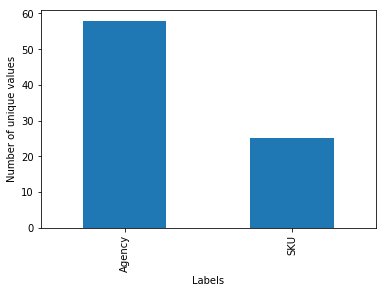

In [189]:
# Calculate number of unique values for each label: num_unique_labels
num_unique_labels = data[['Agency','SKU']].apply(lambda x: pd.Series.nunique(x))

# Plot number of unique values for each label
num_unique_labels.plot(kind='bar');

# Label the axes
plt.xlabel('Labels')
plt.ylabel('Number of unique values')

In [190]:
train = pd.concat([pd.get_dummies(data[['Agency','SKU']]),
                   data[NUMERIC]],axis=1)
train.shape

(21000, 106)

In [192]:
X = train.drop('Volume',axis=1)
y = train['Volume']

### Split Train/Test Sets

In [193]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [194]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16800, 105), (4200, 105), (16800,), (4200,))

### Specify the model

In [195]:
# Import classifiers
from sklearn.linear_model import LinearRegression

clf = LinearRegression()
clf.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [197]:
clf.score(X_test,y_test)

0.46907485292042306

In [198]:
clf.score(X_train,y_train)

0.45684613329052781

### Train/Validation Set Evaluation 

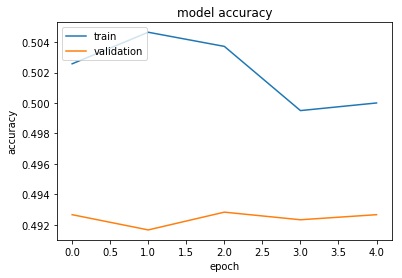

In [18]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

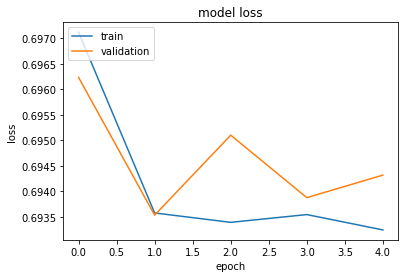

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Test Set Evaluation

In [20]:
# evaluate the model
pred = model.predict(test_X)
pred = np.exp(pred) - 1
pred[1]

array([ 1.45468307,  1.29977894], dtype=float32)

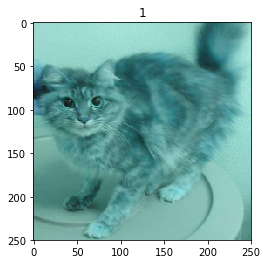

In [21]:
idx = 450
img = test_X[idx].reshape(3,250,250)
plt.imshow(img.transpose((1,2,0)))
plt.title(pred[idx][1].astype(int))

***
## 5. Predict the Test set

### Select test model features 

### Make predictions 

***
## 6. Save Results
### Create the Solution 

In [22]:
my_solution.index.name

NameError: name 'my_solution' is not defined

### Save to CSV file 

In [ ]:
my_solution.to_csv("my_solution_six.csv")

***
***
# Rough Work 

In [ ]:
%matplotlib inline